In [1]:
#import sklearn 
import numpy as np
from osgeo import gdal, gdal_array
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os.path
import pathlib
import platform 
import json 
import geopandas as gpd
from shapely.geometry import Point
from pykrige.ok import OrdinaryKriging
import matplotlib as mpl


In [2]:
cwd = pathlib.Path().resolve()
src = cwd.parent
data = src.parent.parent.parent
OS_type = platform.system()

if OS_type == 'Darwin':
    username = 'Mats '
    data_path = os.path.join(data, 'data_tana', 'TAHMO', 'location_tahmo')
    data_path_location = os.path.join(data, 'data_tana')
    
else:
    username = 'Mootje'
    data_path = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data', 'TAHMO')
    data_path_location = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data')

print(f"Welcome {username}, have a wonderful day on your {OS_type} machine. Your data should be located in {data_path}")

Welcome Mats , have a wonderful day on your Darwin machine. Your data should be located in /Users/matskerver/Documents/data_tana/TAHMO/location_tahmo


In [3]:
def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = Affine.translation(min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = Z.shape[0],
            width = Z.shape[1],
            count = 1,
            dtype = Z.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(Z, 1)

In [4]:
data_files = glob.glob(os.path.join(data_path, '*.csv'))

dataframes = {}

for file in data_files:
    station_name = os.path.splitext(os.path.basename(file))[0].split('_')[0]
    df = pd.read_csv(file, index_col = 0, sep =',', parse_dates = True)
    dataframes[station_name] = df

In [5]:
proj = 'EPSG:32737'

In [6]:
counties = gpd.read_file(os.path.join(data_path, 'total_tana_catchement_area_clip_projected.gpkg'))
geo_dataframes = {}

for key in dataframes:
    geometry = [Point(xy) for xy in zip(dataframes[key]['longitude'], dataframes[key]['lattitude'])]
    rain_gdf = gpd.GeoDataFrame(dataframes[key], geometry=geometry)
    geo_dataframes[key] = rain_gdf\
    
#print(geo_dataframes)

Text(0.5, 1.0, 'Tana Basin Area Kenya')

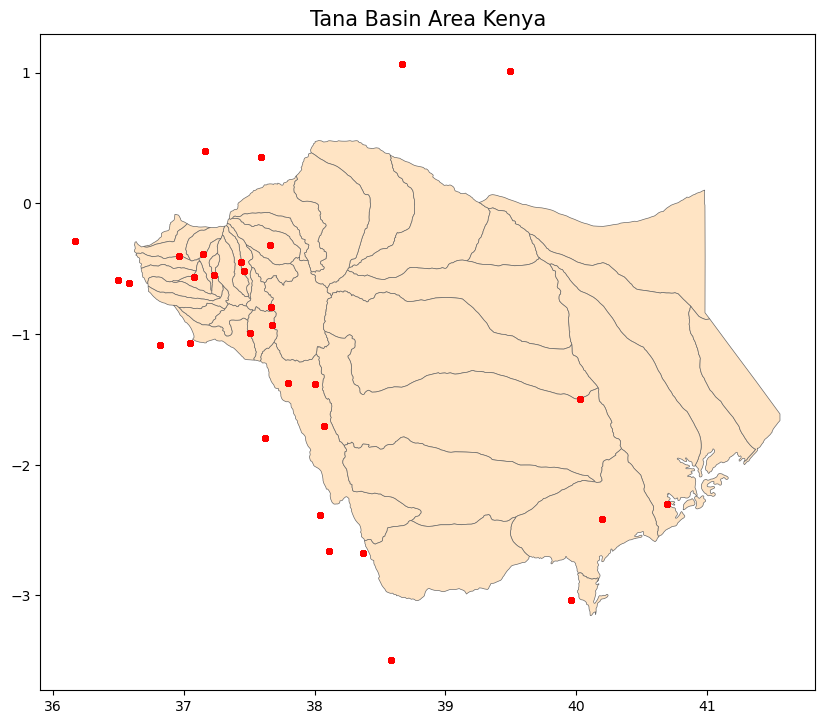

In [7]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Stylize plots
plt.style.use('bmh')

# Plot data
counties.plot(ax = ax, color = 'bisque', edgecolor = 'dimgray')

for key in geo_dataframes:
    geo_dataframes[key].plot(ax = ax, marker = 'o', color = 'red', markersize = 15)
#rain_test_gdf.plot(ax = ax, marker = 'o', color = 'royalblue', markersize = 3)
# Set title
ax.set_title('Tana Basin Area Kenya', fontdict = {'fontsize': '15', 'fontweight' : '3'})

In [8]:
lon_start, lon_end = 36, 42
lat_start, lat_end = -4, 2
grid_space = 0.01  # Adjust this as needed

# Create 1D arrays for longitude and latitude
#lon_values = np.arange(lon_start, lon_end + grid_space, grid_space, dtype='float64')
#lat_values = np.arange(lat_start, lat_end + grid_space, grid_space, dtype='float64')

grid_lons = np.arange(36, 42, 0.01)
grid_lats = np.arange(-4, 2, 0.01)


In [13]:
lon = []
lat = []
z = []
time_series = []
dataframe_count = 0

for key in dataframes:
    # Extract longitude, latitude, z-value, and time series for each key
    lon.extend(dataframes[key]['longitude'])
    lat.extend(dataframes[key]['lattitude'])
    z.extend(dataframes[key]['te_mean'])  # Adjust 'z_value' according to your data
    time_series.extend(dataframes[key].index)  # Adjust 'time_series' according to your data
    dataframe_count += 1

z_cur = np.zeros(2045)

z_avg_value = np.nanmean(z)

nan_mask = np.isnan(z)
z = np.where(nan_mask, z_avg_value, z)

for t in range(0, 13):#int(len(time_series)/ dataframe_count)):
    lon_cur, lat_cur, z_cur = np.zeros(31), np.zeros(31), np.zeros(31)
    z_list = []
    ss_list = []
    for f in range(0, dataframe_count):
        index = 2046*f + t
        lon_cur[f] = lon[index]
        lat_cur[f] = lat[index]
        z_cur[f] = z[index]
    OK = OrdinaryKriging(lon_cur, lat_cur, z_cur, variogram_model='gaussian', verbose=False, enable_plotting=False,nlags=10, weight=True)
    z1, ss1 = OK.execute('grid', grid_lons, grid_lats)
    z_list.append(z1)
    ss_list.append(ss1)



    

            
    
       
        
    

In [14]:
# Create a custom color gradient for our colormap.
cdict = {  'red'  :  [(0.0, 1.0, 1.0),
                      (0.05, 0.59, 0.59),
                      (1.0, 0.0, 0.0)],
         'green':  [(0.0, 1.0, 1.0),
                    (0.05, 0.29, 0.29),
                    (0.2, 1.0, 1.0),
                    (1.0, 0.0, 0.0)],
         'blue' :  [(0.0, 0.88, 0.88), 
                    (0.05, 0.1, 0.1),
                    (0.2, 1.0, 1.0),
                    (1.0, 1.0, 1.0)]}

cm = mpl.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

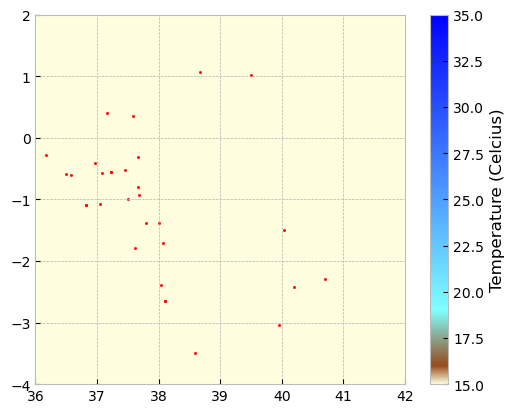

In [39]:
path_shape = os.path.join(data_path, 'total_tana_catchement_area_clip_projected.gpkg')

options = gdal.WarpOptions(cutlineDSName=path_shape,
                           cropToCutline=True,  # Crop the output to the extent of the cutline
                           dstNodata=0,  # Set nodata value for areas outside the cutline
                           dstSRS='EPSG:32737')  # Specify the output coordinate system if needed




ras = gdal.Translate('temp.tif', gdal_array.OpenArray(z_list[0]), format = 'MEM',
                         outputSRS = 'EPSG:32737', outputBounds = [36, 42, -4, 2])
ras_clipped = gdal.Warp('temp_clip.tif', ras, options=options)
cax = plt.imshow(np.flipud(ras_clipped.GetRasterBand(1).ReadAsArray()), cmap=cm, vmin=15, vmax=35, extent=(36, 42, -4, 2), origin='lower')
plt.scatter(lon_cur, lat_cur, s=10, c='red', marker='.')
cbar=plt.colorbar(cax, label='Temperature (Celcius)')
    # Label the figure with the year and month for easy identification.
    #plt.title('Monthly Precipitation in Ontario - ' + months[means[i]['month'][0] - 4] + '-' + str(means[i]['year'][0]))

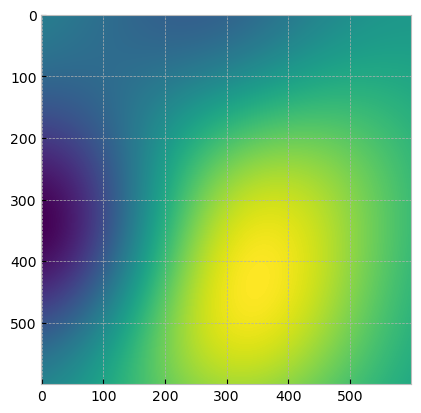

In [12]:
plt.imshow(z_list[0])
plt.show()